<a href="https://colab.research.google.com/github/aissam-out/Predicting-Heart-Disease/blob/master/ML_algos_multi_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import resources

In [0]:
# import modules
import matplotlib
import numpy as np
import pandas as pd 
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
matplotlib.use('Agg')
%matplotlib inline

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# loading the dataset
downloaded_train_v = drive.CreateFile({'id':'********************'}) 
downloaded_train_l = drive.CreateFile({'id':'********************'}) 

downloaded_train_v.GetContentFile('train_values.csv')
downloaded_train_l.GetContentFile('train_labels.csv')

df_train_v = pd.read_csv("train_values.csv")
df_train_l = pd.read_csv("train_labels.csv")

# load the test set
downloaded_test_v = drive.CreateFile({'id':'**************'})
downloaded_test_v.GetContentFile('test_values.csv')

df_test_v = pd.read_csv("test_values.csv")
test_indabax = df_test_v.copy()

# Data Exploration & preprocessing

## Train Data

In [0]:
# replace strings with numbers
df_train_v['thal'] = df_train_v['thal'].replace({'normal':0,'reversible_defect':1, 'fixed_defect':2})
df_train_v = pd.get_dummies(df_train_v, columns=['slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels'])

In [0]:
# Feature engineering 1
df_train_v["added"]=df_train_v['oldpeak_eq_st_depression']/df_train_v['max_heart_rate_achieved']

In [0]:
# drop ID column
df_train_v = df_train_v.drop("patient_id", axis=1)
df_train_l = df_train_l.drop("patient_id", axis=1)

In [0]:
# Feature engineering 2 : extra drops 
df_train_v = df_train_v.drop(["fasting_blood_sugar_gt_120_mg_per_dl",
                              "oldpeak_eq_st_depression",
                              "slope_of_peak_exercise_st_segment_1",
                              "slope_of_peak_exercise_st_segment_3",
                              "chest_pain_type_1",
                              "chest_pain_type_2",
                              "chest_pain_type_3",
                              "num_major_vessels_1",
                              "num_major_vessels_2",
                              "num_major_vessels_3"], 
                             axis=1)

In [0]:
df_train_v.sample()

,thal,resting_blood_pressure,resting_ekg_results,serum_cholesterol_mg_per_dl,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_2,chest_pain_type_4,num_major_vessels_0,added
88,0,150,0,168,1,57,174,0,0,0,1,0.009195


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,0:9]

,0,1,2,3,4,5,6,7,8
0,thal,resting_blood_pressure,resting_ekg_results,serum_cholesterol_mg_per_dl,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_2


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,9:14]

,9,10,11
0,chest_pain_type_4,num_major_vessels_0,added


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,14:]

""
0


In [0]:
# convert to values
df_train_v = (df_train_v.values).astype('float32')
df_train_v = preprocessing.scale(df_train_v)
df_train_l = df_train_l.values.astype('float32')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [0]:
df_train_v.shape

(180, 12)

In [0]:
# VALIDATION
df_train_v, df_VALIDATION_v, df_train_l, df_VALIDATION_l = train_test_split(df_train_v, df_train_l, test_size=0.055)

In [0]:
df_VALIDATION_v.shape

(10, 12)

In [0]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

# convert column-vector to 1d array
y_train = np.ravel(y_train)

x_train shape: (136, 12)
136 train samples


## Indaba Test 

In [0]:
# load the test set
downloaded_test_v = drive.CreateFile({'id':'*******************'})
downloaded_test_v.GetContentFile('test_values.csv')

df_test_v = pd.read_csv("test_values.csv")
test_indabax = df_test_v.copy()

# preprocess test set
test_indabax['thal'] = test_indabax['thal'].replace({'normal':0,'reversible_defect':1, 'fixed_defect':2})
test_indabax = pd.get_dummies(test_indabax, columns=['slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels'])
test_indabax["added"]=test_indabax['oldpeak_eq_st_depression']/test_indabax['max_heart_rate_achieved']
test_indabax = test_indabax.drop("patient_id",axis=1)
test_indabax = test_indabax.drop(["fasting_blood_sugar_gt_120_mg_per_dl",
                                  "oldpeak_eq_st_depression",
                                  "slope_of_peak_exercise_st_segment_1",
                                  "slope_of_peak_exercise_st_segment_3",
                                  "chest_pain_type_1",
                                  "chest_pain_type_2",
                                  "chest_pain_type_3",
                                  "num_major_vessels_1",
                                  "num_major_vessels_2",
                                  "num_major_vessels_3"], 
                                 axis=1)
test_indabax = (test_indabax.values).astype('float32')
test_indabax = preprocessing.scale(test_indabax)

# load submission form
sub_form = drive.CreateFile({'id':'***********************'})
sub_form.GetContentFile('submission_format.csv')

df_sub = pd.read_csv("submission_format.csv")
df_sub_indabax = df_sub.copy()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


# Training

In [0]:
def training_function():
  x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
  y_train = np.ravel(y_train)
  
  folds = 10
  param_comb = 100

  skf = StratifiedKFold(n_splits=folds, shuffle = True)
  
  params = {
          'min_child_weight': [2, 3],
          'gamma': [5, 7, 9],
          'learning_rate': [0.7, 0.1],
          'colsample_bytree': [0.7, 0.8],
          'max_depth': [300, 400, 500],
          'n_estimators': [5000, 8000, 10000],
          }

  model = xgb.XGBClassifier(subsample=0.5, objective='binary:logistic', silent=True, nthread=1)
  
  random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb,
                                     scoring='neg_log_loss', n_jobs=4, cv=skf.split(x_train, y_train), verbose=2)
  
  random_search.fit(x_train, y_train)
  
  print('\n Best estimator:')
  print(random_search.best_estimator_)
  print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
  print(random_search.best_score_ * 2 - 1)
  print('\n Best hyperparameters:')
  print(random_search.best_params_)
  
  predictions = random_search.predict_proba(x_test)[:, 1]
  loss = log_loss(y_test, predictions)

  print("log loss is :", loss)
  
  return random_search.best_estimator_

In [0]:
model_best = training_function()

# Useful functions

In [0]:
global_evaluation = {}

def indabax_model(test_num):
  x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
  y_train = np.ravel(y_train)
  
  model = xgb.XGBClassifier(min_child_weight= 3, 
                            max_depth= 6, 
                            learning_rate= 0.1, 
                            gamma= 0.95, 
                            subsample=0.8,
                            rate_drop=0.1,
                            n_estimators=60)

  model.fit(x_train, y_train)

  predictions = model.predict_proba(x_test)[:, 1]
  loss = log_loss(y_test, predictions)
  
  global_evaluation.update({"model_%d" %test_num : [loss.round(4)]})

  print("log loss of test %d is : %.4f" %(test_num, loss))
  
  return model

def prep_results(model, file):
  predictions_indabax = model.predict_proba(test_indabax)
  results = pd.DataFrame(predictions_indabax)
  df_sub_indabax["heart_disease_present"] = results
  df_sub_indabax.to_csv(file, header=True, index=False)
  
  return df_sub_indabax

def agregation_model(file, test_num):
  model = indabax_model(test_num)
  df_sub_indabax = prep_results(model, file)
  
  return model

def validation_test(model_name):
  loaded_model = joblib.load(model_name)
  validation_pred = loaded_model.predict_proba(df_VALIDATION_v)[:, 1]
  validation_loss = log_loss(np.ravel(df_VALIDATION_l), validation_pred)
  
  print("validation log loss is :", validation_loss)

# Save results

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Multi tests

In [0]:
for i in range(1,50):
  model = agregation_model("multi_%d.csv" %i, i)
  joblib.dump(model, "model_%d.sav" %i)

log loss of test 1 is : 0.4946
log loss of test 2 is : 0.4334
log loss of test 3 is : 0.3949
log loss of test 4 is : 0.3649
log loss of test 5 is : 0.3908
log loss of test 6 is : 0.4963
log loss of test 7 is : 0.3044
log loss of test 8 is : 0.6103
log loss of test 9 is : 0.5840
log loss of test 10 is : 0.4137
log loss of test 11 is : 0.5125
log loss of test 12 is : 0.3693
log loss of test 13 is : 0.4199
log loss of test 14 is : 0.4106
log loss of test 15 is : 0.4976
log loss of test 16 is : 0.3387
log loss of test 17 is : 0.3240
log loss of test 18 is : 0.3932
log loss of test 19 is : 0.4169
log loss of test 20 is : 0.4079
log loss of test 21 is : 0.5893
log loss of test 22 is : 0.3515
log loss of test 23 is : 0.3285
log loss of test 24 is : 0.3981
log loss of test 25 is : 0.3371
log loss of test 26 is : 0.2450
log loss of test 27 is : 0.4688
log loss of test 28 is : 0.5068
log loss of test 29 is : 0.3270
log loss of test 30 is : 0.3469
log loss of test 31 is : 0.4067
log loss of test 

#  Copy to Drive

In [0]:
%cp multi_36.csv gdrive/'My Drive'/'Colab Notebooks'/indabax

# Evaluation

In [0]:
global_evaluation = pd.DataFrame.from_dict(global_evaluation, orient='index',columns=['Log loss'])
global_evaluation.sort_values(by=['Log loss']).head()

,Log loss
model_36,0.2161
model_39,0.2421
model_26,0.2450
model_47,0.2481
model_7,0.3044


In [0]:
mean = pd.DataFrame.from_dict(global_evaluation.mean(axis = 0)).T
mean.rename(index={0:'mean'}, inplace=True)
mean

,Log loss
mean,0.402922


# Validation tests

In [0]:
for i in global_evaluation.sort_values(by=['Log loss']).head().index :
  validation_test(i +".sav")

validation log loss is : 0.5844566082581878
validation log loss is : 0.7026831628754735
validation log loss is : 0.6439419804140926
validation log loss is : 0.8166165122762322
validation log loss is : 0.7380747674033046


# LAB

In [0]:
model_lab = agregation_model("LAB.csv", 99)

log loss of test 99 is : 0.4427


In [0]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

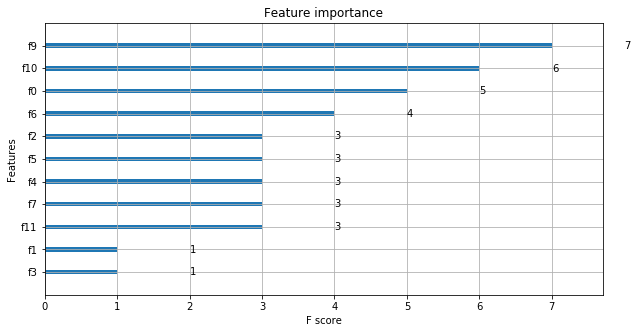

In [0]:
plot_features(model_lab, (10,5))

In [0]:
model_lab.feature_importances_

array([0.1198756 , 0.08122625, 0.08518069, 0.08386566, 0.09239529,
       0.06791864, 0.09586107, 0.08473256, 0.        , 0.09432235,
       0.09223466, 0.10238716], dtype=float32)